# Cartpole Problem

The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    x & \theta & \dot{x} & \dot{\theta}
    \end{bmatrix}^T
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    F_{x}
    \end{bmatrix}^T
\end{equation*}
$$

The goal is to swing the pendulum upright:

$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0 & 0 & 0
    \end{bmatrix}^T
\end{equation*}
$$

**Note**: The force is constrained between $-1$ and $1$. This is achieved by
instead fitting for unconstrained actions and then applying it to a squashing
function $\tanh(\textbf{u})$. This is directly embedded into the dynamics model
in order to be auto-differentiated. This also means that we need to apply this
transformation manually to the output of our iLQR at the end.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [4]:
from ilqr.cost import QRCost, FiniteDiffCost
from ilqr.mujoco_dynamics import MujocoDynamics
from ilqr.mujoco_controller import iLQR
from ilqr.examples.cartpole import CartpoleDynamics
from ilqr.dynamics import constrain

from scipy.optimize import approx_fprime

import mujoco_py
from mujoco_py import MjViewer
import os

In [5]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = xs[-1]
    print("iteration", iteration_count, info, J_opt, final_state)

In [6]:
xml_path = os.path.join('..', 'ilqr', 'xmls', 'inverted_pendulum.xml')
dynamics = MujocoDynamics(xml_path, frame_skip = 2, use_multiprocessing = True)
print(dynamics.dt)


Finished loading process 32440
Finished loading process 32441
Finished loading process 32442
Finished loading process 32443
Finished loading process 32444
Finished loading process 32445
Finished loading process 32446
Finished loading process 32447
Finished loading process 32448
Finished loading process 32449
Finished loading process 32450
Finished loading process 32451
0.04
Finished loading process 32452
Finished loading process 32453
Finished loading process 32454
Finished loading process 32455


In [7]:
x_goal = np.array([0.0, 0.0, 0.0, 0.0])

# Instantenous state cost.
Q = np.eye(4)
Q[0, 0] = 10.0
Q[1, 1] = 10.0


# Terminal state cost.
Q_terminal = 100 * Q

# Instantaneous control cost.
R = 10 * np.eye(1)

cost1 = QRCost(Q, R, Q_terminal=Q_terminal, x_goal=x_goal)

In [8]:
N = 100
x0 = np.array([0.0, np.pi - 1, 0.0, 0.0])
us_init = np.array([[-4.76751939e-01],
 [ 3.34490970e-01],
 [-3.99608551e-01],
 [ 8.41882163e-01],
 [-8.93302461e-01],
 [-3.57273055e-01],
 [-3.32158856e-01],
 [-4.82030121e-01],
 [-6.84388675e-01],
 [-4.26475287e-01],
 [-4.90913171e-01],
 [ 1.14754770e-01],
 [ 3.90275383e-01],
 [-4.36421243e-01],
 [ 5.57806778e-01],
 [ 7.83813923e-01],
 [-3.27778717e-01],
 [ 8.00582346e-01],
 [-8.49640982e-01],
 [-5.69222128e-01],
 [ 2.58447724e-01],
 [ 6.02857039e-01],
 [-6.11855326e-01],
 [ 7.00853348e-01],
 [-9.31090157e-01],
 [ 4.97665652e-01],
 [ 2.45721323e-01],
 [-1.92025996e-01],
 [ 2.72219728e-02],
 [ 7.95701514e-01],
 [-8.92320606e-01],
 [ 3.22802941e-02],
 [ 2.69562194e-01],
 [-1.46125346e-01],
 [-3.15934186e-02],
 [ 6.61809200e-01],
 [ 4.76622656e-01],
 [-9.78007260e-01],
 [ 5.73481914e-01],
 [-1.28208542e-02],
 [ 1.48147746e-01],
 [ 1.39421731e-04],
 [ 1.08812740e-01],
 [ 6.16007441e-01],
 [ 2.66982969e-01],
 [-2.09250070e-02],
 [ 6.04343953e-02],
 [ 4.14836049e-01],
 [-7.01346473e-01],
 [ 2.94563133e-01],
 [-3.07180590e-01],
 [ 6.53429823e-01],
 [ 3.87696411e-01],
 [-1.60361255e-01],
 [-7.91982930e-01],
 [ 3.04331662e-01],
 [-3.33057338e-01],
 [-1.45487867e-01],
 [-4.48293362e-01],
 [-4.56753222e-01],
 [-5.63113978e-02],
 [ 9.17106858e-01],
 [-7.79117478e-01],
 [-7.74944928e-01],
 [ 1.26081663e-01],
 [ 8.11397037e-02],
 [-6.58667412e-01],
 [ 9.01877119e-01],
 [-7.59017615e-01],
 [-6.54909707e-01],
 [-7.19152458e-01],
 [-8.23250291e-01],
 [-1.96576912e-01],
 [ 3.31076346e-01],
 [-9.59322994e-01],
 [ 6.61615691e-01],
 [-4.48940253e-01],
 [-4.10547311e-01],
 [-8.26340358e-01],
 [ 7.48939731e-01],
 [-8.83894866e-01],
 [ 4.12684469e-01],
 [-4.61578622e-01],
 [-8.29689676e-01],
 [-9.02561735e-01],
 [-2.44970624e-01],
 [ 2.86652487e-01],
 [-8.59512109e-01],
 [-5.89043961e-01],
 [ 6.21286175e-01],
 [-4.02464523e-01],
 [-7.80221770e-01],
 [-7.58513349e-01],
 [ 5.35469863e-01],
 [ 7.43535637e-01],
 [ 9.40814704e-01],
 [-9.31071558e-01],
 [-4.20465454e-01],
 [-1.28056017e-01],
 [-2.09487816e-01]])
#us_init = np.random.uniform(-1, 1, (N, dynamics.action_size))
ilqr = iLQR(dynamics, cost1, N)

In [9]:
t0 = time.time()
J_hist = []
xs, us = ilqr.fit(x0, us_init, n_iterations=500, on_iteration=on_iteration)
print('\n\n\n\n\n')
print('time', time.time() - t0)

iteration 0 accepted 28533.592865501727 [-1.68990073  2.02240946  0.85810789 -7.06819606]
iteration 1 accepted 28337.937259906976 [-1.53735648  3.03662427  2.43844932 -3.97309875]
iteration 2 accepted 24748.232555574876 [-0.55953088  1.83833105  1.25904802 -7.39646247]
iteration 3 accepted 20097.028809760723 [ 0.27200518  2.48730095  0.33879397 -1.33641112]
iteration 4 accepted 19157.301505805743 [ 0.51859017  1.50175603 -0.45249236 -6.08116471]
iteration 5 accepted 18565.423643540635 [ 0.22250916  2.34044415 -1.87455576 -3.35862623]
iteration 6 accepted 16029.753929989718 [ 0.45303979  2.18207339 -2.17149806  0.83303927]
iteration 7 accepted 14085.160621486999 [ 0.27257567  1.54854681 -2.16703839 -2.44765355]
iteration 8 accepted 13659.126147011382 [ 0.19233264  1.39107892 -2.00650503 -2.07016802]
iteration 9 accepted 13212.147362849682 [ 0.20838531  1.50484068 -1.79485667 -0.95668904]
iteration 10 accepted 13139.11343985025 [ 0.24365636  1.39265868 -1.68729857 -0.89803444]
iteration 

iteration 99 accepted 7436.728734052015 [ 0.00037258 -0.01994468  0.1104354   0.05678553]
iteration 100 accepted 7404.88615644955 [ 0.03002057 -0.00217309  0.01706502  0.01479674]
iteration 101 accepted 7367.016629217394 [-0.00385318 -0.02043661  0.10895398  0.05577732]
iteration 102 accepted 7351.615880570454 [-0.02798183 -0.03209954  0.16891717  0.08163894]
iteration 103 accepted 7330.680132517739 [-0.00938818 -0.02328153  0.12256317  0.06146826]
iteration 104 accepted 7286.058300505477 [ 0.01652904 -0.00765902  0.04101851  0.02477432]
iteration 105 accepted 7253.181961534333 [ 0.00487914 -0.0146688   0.07670936  0.04085455]
iteration 106 accepted 7214.209570495781 [ 0.00269161 -0.01371786  0.07180483  0.03768942]
iteration 107 accepted 7206.381933426956 [-0.03229173 -0.03432074  0.17626716  0.0852952 ]
iteration 108 accepted 7188.472297625457 [ 0.03124975  0.0014807  -0.0189808  -0.00126201]
iteration 109 accepted 7132.907540227161 [ 0.02194645 -0.00369682  0.00951305  0.01119299]
i

iteration 190 accepted 4629.206051091157 [ 0.00275942  0.00220191 -0.01240398 -0.0057431 ]
iteration 191 accepted 4627.874760930068 [ 0.00181407  0.00055826 -0.00491342 -0.00197458]
iteration 192 accepted 4604.393470775636 [ 0.00264679  0.00194832 -0.01135556 -0.00520141]
iteration 193 accepted 4596.713323168863 [ 0.00349147  0.00351842 -0.01845881 -0.00879204]
iteration 194 accepted 4583.120056626448 [ 0.00325078  0.00310917 -0.01657751 -0.00784687]
iteration 195 accepted 4572.631823596497 [ 0.00411859  0.00486235 -0.0244101  -0.01183044]
iteration 196 accepted 4543.9533047524465 [ 0.00349161  0.00358831 -0.01874599 -0.0089497 ]
iteration 197 accepted 4479.6054927235255 [ 0.00234459  0.001789   -0.01033019 -0.00475123]
iteration 198 accepted 4451.359501563399 [ 0.0023007   0.0017652  -0.01019171 -0.00468815]
iteration 199 accepted 4405.81648629797 [ 0.00198394  0.00137332 -0.00824966 -0.00373988]
iteration 200 accepted 4396.452955463361 [ 0.00278908  0.0029371  -0.01533633 -0.00732854

iteration 280 accepted 2421.424859795789 [ 1.35403244e-05  1.99878482e-05 -1.47971544e-04 -4.25340521e-05]
iteration 281 accepted 2416.8776990804345 [ 1.19712913e-05  1.47583403e-05 -1.25658473e-04 -3.09084847e-05]
iteration 282 accepted 2414.019168400746 [ 1.92357809e-06  1.17005339e-05 -9.54729394e-05 -1.85618577e-05]
iteration 283 accepted 2413.038734653687 [-4.60169444e-06  1.05450031e-05 -7.90591611e-05 -1.22872686e-05]
iteration 284 accepted 2412.5242546356326 [-9.51870995e-06  9.42584586e-06 -6.56931936e-05 -7.01882050e-06]
iteration 285 accepted 2412.333404940819 [-1.20748672e-05  9.04122665e-06 -5.95285149e-05 -4.70536288e-06]
iteration 286 accepted 2412.2127836691325 [-1.37747714e-05  8.52604021e-06 -5.44290530e-05 -2.62067376e-06]
iteration 287 accepted 2412.159073812565 [-1.45977023e-05  8.37556485e-06 -5.23554021e-05 -1.82566849e-06]
iteration 288 accepted 2412.1189890842243 [-1.51885359e-05  8.12178433e-06 -5.03024063e-05 -9.46956835e-07]
iteration 289 accepted 2412.09786

In [10]:
t = np.arange(N + 1) * dynamics.dt
x = xs[:, 0]
x_dot = xs[:, 2]
theta = np.unwrap(xs[:, 1])  # Makes for smoother plots.
theta_dot = xs[:, 3]

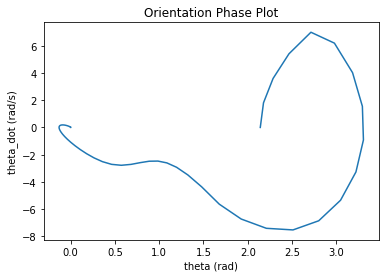

In [11]:
_ = plt.plot(theta, theta_dot)
_ = plt.xlabel("theta (rad)")
_ = plt.ylabel("theta_dot (rad/s)")
_ = plt.title("Orientation Phase Plot")

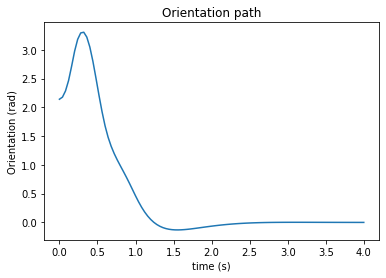

In [12]:
_ = plt.plot(t, theta)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Orientation (rad)")
_ = plt.title("Orientation path")

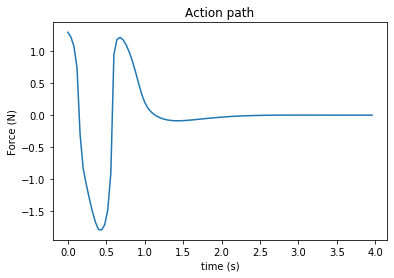

In [13]:
_ = plt.plot(t[:-1], us)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Force (N)")
_ = plt.title("Action path")

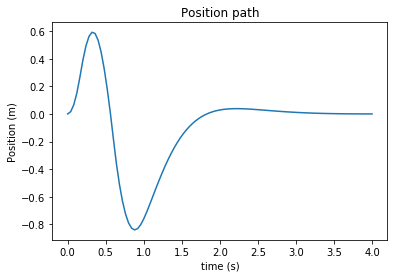

In [14]:
_ = plt.plot(t, x)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Position (m)")
_ = plt.title("Position path")

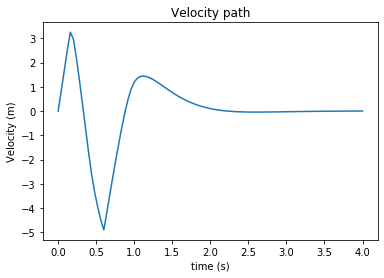

In [15]:
_ = plt.plot(t, x_dot)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Velocity (m)")
_ = plt.title("Velocity path")

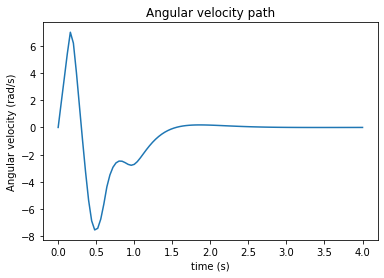

In [16]:
_ = plt.plot(t, theta_dot)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Angular velocity (rad/s)")
_ = plt.title("Angular velocity path")

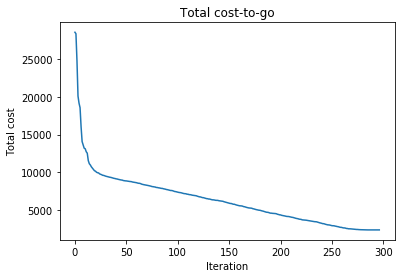

In [17]:
_ = plt.plot(J_hist)
_ = plt.xlabel("Iteration")
_ = plt.ylabel("Total cost")
_ = plt.title("Total cost-to-go")

In [ ]:
viewer = MjViewer(dynamics.sim)
dynamics.set_state(x0)
print(dynamics.get_state())
for i, u in enumerate(us):
    print (i, u)
    print(xs[i+1], dynamics.step(u))
    print('')
    viewer.render()

Creating window glfw
[0.         2.14159265 0.         0.        ]
0 [1.29546631]
[0.01648637 2.17799845 0.82613654 1.80993249] [0.01648637 2.17799845 0.82613654 1.80993249]

1 [1.22149009]
[0.06610958 2.28590216 1.66271736 3.59525077] [0.06610958 2.28590216 1.66271736 3.59525077]

2 [1.07515107]
[0.14936602 2.46553453 2.51099792 5.40729949] [0.14936602 2.46553453 2.51099792 5.40729949]

3 [0.73895263]
[0.26448417 2.71355809 3.24923357 6.99064026] [0.26448417 2.71355809 3.24923357 6.99064026]

4 [-0.3000543]
[0.38924383 2.97879737 2.97019481 6.1897989 ] [0.38924383 2.97879737 2.97019481 6.1897989 ]

5 [-0.82966158]
[0.49236783 3.18361176 2.17830565 4.02080437] [0.49236783 3.18361176 2.17830565 4.02080437]

6 [-1.07786662]
[0.56095468 3.29457081 1.25451876 1.549211  ] [0.56095468 3.29457081 1.25451876 1.549211  ]

7 [-1.29903532]
[ 0.59157005  3.30646139  0.28057186 -0.91883414] [ 0.59157005  3.30646139  0.28057186 -0.91883414]

8 [-1.5031634]
[ 0.58272515  3.22184571 -0.71893523 -3.268

In [19]:
print(dynamics.get_state())
print(xs[-1])

[-1.58829179e-05  7.80945804e-06 -4.78586791e-05  1.05357655e-07]
[-1.58829179e-05  7.80945804e-06 -4.78586791e-05  1.05357655e-07]


In [20]:
#FOR TESTING PURPOSES

In [21]:
dynamics1 = MujocoDynamics(xml_path, frame_skip = 2, bounds = np.array([[-1, 1]]), x_eps = np.sqrt(np.finfo(float).eps), u_eps = np.sqrt(np.finfo(float).eps))
dynamics2 = CartpoleDynamics(0.04)

In [22]:
state = np.array([0.0,0.0,0.0,0.0])
action = np.array([-0.37])

In [23]:
count = 0
def helper(x, u):
    global count
    count += 1
    dynamics1.set_state(x)
    return dynamics1.step(u)

f_x = np.vstack([
            approx_fprime(state, lambda x: helper(x, action)[m], 1.5e-8)
            for m in range(dynamics1.state_size)
        ])
print(f_x)
print(count)

[[ 1.00000000e+00 -1.44920037e-03  3.99265566e-02  1.45175972e-04]
 [ 0.00000000e+00  1.01416466e+00  1.72073698e-04  3.85840789e-02]
 [ 0.00000000e+00 -9.21244655e-02  9.96339017e-01  6.25374752e-03]
 [ 0.00000000e+00  9.01528245e-01  8.51160994e-03  9.39039420e-01]]
20


In [24]:
count = 0

dynamics1.set_state(state)
count += 1
dynamics1.step(action)
center = dynamics1.get_state()
f_x = np.empty((dynamics1.state_size, dynamics1.state_size))

dynamics1.sim.data.ctrl[:] = dynamics1.constrain(action)
for i in range(dynamics1.sim.model.nq):
    dynamics1.sim.data.qpos[:] = state[:dynamics1.sim.model.nq]
    dynamics1.sim.data.qvel[:] = state[dynamics1.sim.model.nq:]

    dynamics1.sim.data.qpos[i] += dynamics1.x_eps
    
    count += 1
    dynamics1.sim.step()
    newstate = np.concatenate([dynamics1.sim.data.qpos, dynamics1.sim.data.qvel])
    deriv = (newstate - center) / dynamics1.x_eps
    f_x[:, i] = deriv

for i in range(dynamics1.sim.model.nv):
    dynamics1.sim.data.qpos[:] = state[:dynamics1.sim.model.nq]
    dynamics1.sim.data.qvel[:] = state[dynamics1.sim.model.nq:]

    dynamics1.sim.data.qvel[i] += dynamics1.x_eps
    
    count += 1
    dynamics1.sim.step()
    newstate = np.concatenate([dynamics1.sim.data.qpos, dynamics1.sim.data.qvel])
    deriv = (newstate - center) / dynamics1.x_eps
    f_x[:, dynamics1.sim.model.nq + i] = deriv
print(f_x)
print(count)

[[ 1.00000000e+00 -1.44920035e-03  3.99265566e-02  1.45175960e-04]
 [ 0.00000000e+00  1.01416466e+00  1.72073720e-04  3.85840788e-02]
 [ 0.00000000e+00 -9.21244659e-02  9.96339018e-01  6.25374727e-03]
 [ 0.00000000e+00  9.01528247e-01  8.51161033e-03  9.39039417e-01]]
5


In [25]:
count = 0
def helper(x, u):
    global count
    count += 1
    dynamics1.set_state(x)
    return dynamics1.step(u)

f_u = np.vstack([
            approx_fprime(action, lambda u: helper(state, u)[m], dynamics1.u_eps)
            for m in range(dynamics1.state_size)
        ])

print(f_u)
print(count)

[[ 0.00642402]
 [-0.01505111]
 [ 0.32022242]
 [-0.74450151]]
8


In [26]:
count = 0

dynamics1.set_state(state)
count += 1
dynamics1.step(action)
center = dynamics1.get_state()
f_u = np.empty((dynamics1.state_size, dynamics1.action_size))


for i in range(dynamics1.action_size):
    dynamics1.sim.data.qpos[:] = state[:dynamics1.sim.model.nq]
    dynamics1.sim.data.qvel[:] = state[dynamics1.sim.model.nq:]

    action[i] += dynamics1.u_eps
    dynamics1.sim.data.ctrl[:] = dynamics1.constrain(action)
    
    count += 1
    dynamics1.sim.step()
    newstate = np.concatenate([dynamics1.sim.data.qpos, dynamics1.sim.data.qvel])
    deriv = (newstate - center) / dynamics1.u_eps
    f_u[:, i] = deriv

    action[i] -= dynamics1.u_eps
print(f_u)
print(count)

[[ 0.00642402]
 [-0.01505111]
 [ 0.32022242]
 [-0.74450151]]
2


In [10]:
from mujoco_py import MjSimPool

ImportError: cannot import name 'MjSimPool' from 'mujoco_py' (/Users/jimwang/mujoco-py/mujoco_py/__init__.py)

In [13]:
import multiprocessing as mp
print(mp.cpu_count())

16


In [14]:
7 // 2

3